In [1]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 7
n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'
pv_method = 'CL'

base_day = 10
prediction_day = base_day
slide = base_day

profit_percentage = 0.1
loss_percentage = 0.1

# Import packages


In [2]:
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import math
import matplotlib.dates as mdates
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

# Load data


In [3]:
def load_data(stock_name, date_predict_start, data_range, slide_range, n_slide):
    train_data = {}
    test_data = {}
    date_predict_start = datetime.datetime.strptime(
        date_predict_start, '%Y-%m-%d').date()
    date_data_start_list = []
    date_predict_start_list = []
    date_predict_end_list = []
    test_data_start_list = []
    all_data = yf.Ticker(stock_name).history(period='max')
    all_data.index = all_data.index.date
    check = date_predict_start in all_data.index
    while (check == False):
        date_predict_start = date_predict_start + \
            relativedelta(days=+1)
        check = date_predict_start in list(all_data.index)
    predict_start = all_data.index.get_loc(date_predict_start)
    for i in range(n_slide):
        predict_end = predict_start + data_range
        date_predict_end = all_data.iloc[predict_end].name
        data_start = predict_start - data_range
        date_data_start = all_data.iloc[data_start].name
        train_data['data_' + str(i)] = all_data.iloc[data_start:predict_start]
        test_data['data_' + str(i)] = all_data.iloc[predict_start:predict_end]
        date_data_start_list.append(date_data_start)
        date_predict_start_list.append(date_predict_start)
        date_predict_end_list.append(date_predict_end)
        test_data_start_list.append(test_data['data_' + str(i)].index[0])
        data_start = data_start + slide_range
        predict_start = predict_start + slide_range
        train_data['data_' + str(i)] = train_data['data_' +
                                                  str(i)].reset_index(drop=False)
        test_data['data_' + str(i)] = test_data['data_' +
                                                str(i)].reset_index(drop=False)

    return train_data, test_data, all_data, test_data_start_list


# Data preprocessing


In [4]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        price = data[i]['Close']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(price)):
            if idx < pv_range:
                if price[idx] == price.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if price[idx] == price.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [5]:
def find_data_pv_HL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        high = data[i]['High']
        low = data[i]['Low']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(high)):
            if idx < pv_range and idx>0:
                if high[idx] == high.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = high[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if low[idx] == low.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = low[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if high[idx] == high.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = high[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if low[idx] == low.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = low[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [6]:
def preprocessing(train_data, test_data, pv_range, pv_method):
    if pv_method == 'CL':
        find_data_pv_CL_function(train_data, pv_range)
        find_data_pv_CL_function(test_data, pv_range)
    elif pv_method == 'HL':
        find_data_pv_HL_function(train_data, pv_range)
        find_data_pv_HL_function(test_data, pv_range)
    else :
        print('worng pv_method')


# Built Model


Get signal


In [7]:
def data_to_harmonics_function(data_stock, data_range):
    harmonics = {}
    for i in data_stock:
        harmonics[i] = {}
        # get data_stock's infomation
        data = data_stock[i]['Close']
        array_data = np.array(data)
        n_data = array_data.size
        time_data = np.arange(0, n_data)

        # detrend data
        # find linear trend in data
        Polynomial = np.polyfit(time_data, array_data, 1)
        data_notrend = array_data - Polynomial[0] * time_data    # detrended x

        # fft process
        data_freqdom = fft.fft(data_notrend, n=n_data)
        frequence = fft.fftfreq(n=n_data, d=1)
        f_positive = frequence[np.where(frequence > 0)]
        data_freqdom_positive = data_freqdom[np.where(frequence > 0)]

        # sort indexes
        indexes = list(range(f_positive.size))      # frequencies
        # sort method 1
        # indexes.sort(key = lambda i: np.absolute(frequence[i]))     # sort indexes by frequency, lower -> higher
        # sort method 2 :
        # sort indexes by amplitudes, lower -> higher
        indexes.sort(key=lambda i: np.absolute(data_freqdom[i]))
        indexes.reverse()       # sort indexes by amplitudes, higher -> lower

        # get data_all_time'size
        time_transfer = np.arange(0, data_range*2)

        # get harmonics
        for j in indexes:
            ampli = np.absolute(
                data_freqdom_positive[j]) / n_data     # amplitude
            phase = np.angle(data_freqdom_positive[j])      # phase
            harmonics[i][j] = ampli * \
                np.cos(2 * np.pi * f_positive[j] * time_transfer + phase)
    return harmonics


In [8]:
def mix_harmonics_function(harmonics, n_harm_lower_limit, n_harm_upper_limit):
    processed_signal = {}
    for i in harmonics:
        processed_signal[i] = {}
        for n_harm in range(n_harm_lower_limit, n_harm_upper_limit+1):
            mixed_harmonic = np.zeros(len(harmonics[i][0]))
            # for j in range(n_harm):
            for j in range(2, n_harm):
                mixed_harmonic += harmonics[i][j]
            processed_signal[i][n_harm] = pd.DataFrame(
                {'Close': mixed_harmonic})
    return processed_signal


Signal processing


In [9]:
def find_signal_pv_function(signal, pv_range):
    pd.options.mode.chained_assignment = None
    for i in signal:
        for j in signal[i]:
            data = signal[i][j]['Close']
            signal[i][j]['peaks'] = pd.Series(dtype='float64')
            signal[i][j]['valleys'] = pd.Series(dtype='float64')
            signal[i][j]['pv'] = pd.Series(dtype='str')
            for idx in range(0, len(data)):
                if idx < pv_range and idx>0:
                    if data[idx] == data.iloc[0:pv_range*2+1].max():
                        signal[i][j]['peaks'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'peak'
                    if data[idx] == data.iloc[0:pv_range*2+1].min():
                        signal[i][j]['valleys'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'valley'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                    signal[i][j]['peaks'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                    signal[i][j]['valleys'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'valley'


In [10]:
def find_signal_lead_train_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            # processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].head(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']


In [11]:
def build_model(train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range):
    harmonics = data_to_harmonics_function(train_data, data_range)
    processed_signal = mix_harmonics_function(
        harmonics, n_harm_lower_limit, n_harm_upper_limit)
    find_signal_pv_function(processed_signal, pv_range)
    find_signal_lead_train_function(train_data, processed_signal)
    return harmonics, processed_signal


# Select model


In [12]:
def get_fit_error_function(processed_signal, fit_method):
    errors = {}
    error = []
    for i in processed_signal:
        errors[i] = {}
        for j in processed_signal[i]:
            signal_dropna = processed_signal[i][j].drop(
                processed_signal[i][j][processed_signal[i][j]['lead'].isna()].index)
            if fit_method == 'mean':
                error = signal_dropna['lead'].mean()
            elif fit_method == 'abs':
                error = abs(signal_dropna['lead']).mean()
            elif fit_method == 'rmse':
                mse = np.square(np.subtract(np.zeros_like(
                    signal_dropna['lead']), signal_dropna['lead'])).mean()
                rmse = math.sqrt(mse)
                error = rmse
            else :
                print('worng fit_method')
            errors[i][j] = error
    return errors


In [13]:
def get_best_fit_harm_function(processed_signal, errors):
    best_error = {}
    best_fit_harm = {}
    for i in processed_signal:
        best_error[i] = pd.Series(errors[i]).abs().min()
        best_fit_harm[i] = pd.Series(errors[i]).abs().idxmin()
    return best_fit_harm, best_error


In [14]:
def find_signal_lead_test_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].tail(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['pv'].loc[p_signal['lead'].index] = 'peak'
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']
            processed_signal[d][p]['pv'].loc[v_signal['lead'].index] = 'valley'


In [15]:
def get_first_lead_function(processed_signal, best_fit_harm):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        harm = best_fit_harm[i]
        temp = processed_signal[i][harm].loc[list(
            processed_signal[i][harm]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i][harm]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [16]:
def select_model(test_data, processed_signal, fit_method):
    errors = get_fit_error_function(processed_signal, fit_method)
    best_fit_harm, best_error = get_best_fit_harm_function(
        processed_signal, errors)
    find_signal_lead_test_function(test_data, processed_signal)
    first_date, lead, pv = get_first_lead_function(
        processed_signal, best_fit_harm)
    return errors, best_fit_harm, best_error, first_date, lead, pv


# Evaluate model


In [17]:
def built_result_table_function(processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv', 'error', 'best_fit'])
    for i in processed_signal:
        result_table.loc[i, 'error'] = round(best_error[i], 2)
        result_table.loc[i, 'best_fit'] = best_fit_harm[i]
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
    result_table['s_date'] = test_data_start_list
    return result_table


In [18]:
def result_table_process_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i] - data_range].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [19]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [20]:
def evaluate_model(processed_signal, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range):
    result_table = built_result_table_function(
        processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
    result_table_process_function(
        result_table, all_data, first_date, data_range)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error


# Draw plot


In [21]:
def find_data_pv_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range and idx>0:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valleys'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valleys'


In [22]:
def draw_plot_result_table(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    test_data_copy = test_data.copy()
    for d in test_data :
        test_data_copy[d].index = test_data[d]['index']
        test_data_copy[d] = test_data_copy[d].drop(test_data_copy[d][test_data_copy[d].index > date_list[-1]].index)
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['Close'], 'gray', label='data', linewidth=3)
    for d in test_data_copy :
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['peaks'],
                    '^', c='royalblue', label='peaks')
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['valleys'], 'v',
                    c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.show()

# Main function


In [23]:
def main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
        n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method):

    # 1. Load data
    train_data, test_data, all_data, test_data_start_list = load_data(
        stock_name, date_predict_start, data_range, slide_range, n_slide)
    # 2. Preprocessing
    preprocessing(train_data, test_data, pv_range, pv_method)
    # 3. Build model
    harmonics, model = build_model(
        train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
    # 4. Select model
    errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
                                                                           model, fit_method)
    # 5. Evaluate model
    result_table, final_error = evaluate_model(
        model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
    print('final_error = ', final_error)
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
        print(result_table)
    draw_plot_result_table(test_data, all_data, result_table, pv_range)
    # return harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error


In [24]:
# main_funtion(
#     stock_name, date_predict_start, data_range, slide_range,
#         n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)

# Lstm function

In [25]:
def preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide):
    x_train = {}
    y_train = {}
    for i in train_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaled_data = scaler.fit_transform(train_data[i]['Close'].values.reshape(-1,1))
        x_train[i] = []
        y_train[i] = []
        # for x in range(base_day+prediction_day, len(scaled_data), slide):
        for x in range(base_day+prediction_day, len(scaled_data)):
            x_train[i].append(scaled_data[x-base_day-prediction_day:x-prediction_day])
            y_train[i].append(scaled_data[x-prediction_day:x])
        x_train[i], y_train[i] = np.array(x_train[i]), np.array(y_train[i])
        # 將x_train數組的形狀轉換為（樣本數，天數，特徵數）的形式，這裡的特徵數為1
        x_train[i] = np.reshape(x_train[i], (x_train[i].shape[0], x_train[i].shape[1], 1))
        y_train[i] = np.reshape(y_train[i], (y_train[i].shape[0], y_train[i].shape[1], 1))
    return x_train, y_train

In [26]:
def LSTM_model(prediction_day, input_shape):
    model = Sequential()
    model.add(LSTM(units = 256, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.4))
    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.4))
    model.add(LSTM(units = 64))
    model.add(Dropout(0.4))
    model.add(Dense(units=prediction_day))
    return model

In [27]:
def build_Lstm_model(train_data, prediction_day, input_shape):
    model = {}
    for i in train_data:
        model[i] = LSTM_model(prediction_day, input_shape)
        model[i].compile(optimizer='adam', 
                    loss='mean_squared_error')
        # model[i].summary()
    return model

In [28]:
def train_Lstm_model(train_data, model, x_train, y_train):
    history = {}
    for i in tqdm(train_data):
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history[i] = model[i].fit(x_train[i], y_train[i], epochs=25, batch_size=32, 
                            callbacks = [earlystopper], validation_split = 0.2, shuffle=True)
    return history

In [29]:
def preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide):
    x_test = {}
    y_test = {}
    for i in test_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        model_inputs = pd.concat((train_data[i]['Close'].iloc[-base_day:], test_data[i]['Close'])).values
        model_inputs = model_inputs.reshape(-1,1)
        model_inputs = scaler.fit_transform(model_inputs)
        x_test[i] = []
        y_test[i] = []
        for x in range(base_day+prediction_day, len(model_inputs), slide):
            x_test[i].append(model_inputs[x-base_day-prediction_day:x-prediction_day])
            y_test[i].append(model_inputs[x-prediction_day:x])
        x_test[i], y_test[i] = np.array(x_test[i]), np.array(y_test[i])
        x_test[i] = np.reshape(x_test[i], (x_test[i].shape[0], x_test[i].shape[1], 1))
        y_test[i] = np.reshape(y_test[i], (y_test[i].shape[0], y_test[i].shape[1], 1))
    return x_test, y_test

In [30]:
def predicting_creat_processed_signal_Lstm(x_test, test_data, model):
    processed_signal = {}
    for i in test_data:
        predicted_prices = model[i].predict(x_test[i])
        processed_signal[i] = {}
        processed_signal[i][0] = pd.DataFrame(
            {'Close': predicted_prices.flatten()}, index=test_data[i].index[:len(predicted_prices.flatten())])
    return processed_signal

In [31]:
def result_table_process_Lstm_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[int(all_data.index.get_loc(result_table.loc[i, 's_date'])) + first_date[i]].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [32]:
# 1. Load data
train_data, test_data, all_data, test_data_start_list = load_data(
    stock_name, date_predict_start, data_range, slide_range, n_slide)
# 2. Preprocessing
preprocessing(train_data, test_data, pv_range, pv_method)
x_train, y_train = preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide)
x_test, y_test = preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/25
6/6 [==============================] - 7s 279ms/step - loss: 0.0515 - val_loss: 0.2136
Epoch 2/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0321 - val_loss: 0.1164
Epoch 3/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0293 - val_loss: 0.2005
Epoch 4/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0261 - val_loss: 0.1485
Epoch 5/25
6/6 [==============================] - 0s 56ms/step - loss: 0.0253 - val_loss: 0.1687
Epoch 6/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0244 - val_loss: 0.1353
Epoch 7/25
6/6 [==============================] - 0s 56ms/step - loss: 0.0246 - val_loss: 0.1567
Epoch 7: early stopping


 10%|█         | 1/10 [00:09<01:21,  9.11s/it]

Epoch 1/25
6/6 [==============================] - 6s 328ms/step - loss: 0.0677 - val_loss: 0.2536
Epoch 2/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0416 - val_loss: 0.2256
Epoch 3/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0359 - val_loss: 0.1813
Epoch 4/25
6/6 [==============================] - 0s 53ms/step - loss: 0.0340 - val_loss: 0.1904
Epoch 5/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0324 - val_loss: 0.1995
Epoch 6/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0323 - val_loss: 0.2343
Epoch 7/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0313 - val_loss: 0.2165
Epoch 8/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0300 - val_loss: 0.2178
Epoch 8: early stopping


 20%|██        | 2/10 [00:17<01:11,  8.92s/it]

Epoch 1/25
6/6 [==============================] - 6s 274ms/step - loss: 0.1265 - val_loss: 0.2625
Epoch 2/25
6/6 [==============================] - 0s 61ms/step - loss: 0.0723 - val_loss: 0.2468
Epoch 3/25
6/6 [==============================] - 0s 59ms/step - loss: 0.0659 - val_loss: 0.2447
Epoch 4/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0545 - val_loss: 0.1864
Epoch 5/25
6/6 [==============================] - 0s 56ms/step - loss: 0.0484 - val_loss: 0.1946
Epoch 6/25
6/6 [==============================] - 0s 57ms/step - loss: 0.0511 - val_loss: 0.1693
Epoch 7/25
6/6 [==============================] - 0s 59ms/step - loss: 0.0491 - val_loss: 0.1572
Epoch 8/25
6/6 [==============================] - 0s 56ms/step - loss: 0.0492 - val_loss: 0.1603
Epoch 9/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0432 - val_loss: 0.1549
Epoch 10/25
6/6 [==============================] - 0s 57ms/step - loss: 0.0444 - val_loss: 0.1693
Epoch 11/25
6/6 [===========

 30%|███       | 3/10 [00:28<01:07,  9.62s/it]

Epoch 1/25
6/6 [==============================] - 6s 288ms/step - loss: 0.1553 - val_loss: 0.2271
Epoch 2/25
6/6 [==============================] - 0s 65ms/step - loss: 0.0801 - val_loss: 0.2183
Epoch 3/25
6/6 [==============================] - 0s 62ms/step - loss: 0.0664 - val_loss: 0.1902
Epoch 4/25
6/6 [==============================] - 0s 60ms/step - loss: 0.0607 - val_loss: 0.1570
Epoch 5/25
6/6 [==============================] - 0s 64ms/step - loss: 0.0518 - val_loss: 0.1551
Epoch 6/25
6/6 [==============================] - 0s 62ms/step - loss: 0.0505 - val_loss: 0.1069
Epoch 7/25
6/6 [==============================] - 0s 61ms/step - loss: 0.0499 - val_loss: 0.1088
Epoch 8/25
6/6 [==============================] - 0s 60ms/step - loss: 0.0469 - val_loss: 0.0868
Epoch 9/25
6/6 [==============================] - 0s 59ms/step - loss: 0.0457 - val_loss: 0.0923
Epoch 10/25
6/6 [==============================] - 0s 57ms/step - loss: 0.0453 - val_loss: 0.0792
Epoch 11/25
6/6 [===========

 40%|████      | 4/10 [00:42<01:08, 11.47s/it]

Epoch 1/25
6/6 [==============================] - 6s 230ms/step - loss: 0.1518 - val_loss: 0.3345
Epoch 2/25
6/6 [==============================] - 0s 51ms/step - loss: 0.0750 - val_loss: 0.2770
Epoch 3/25
6/6 [==============================] - 0s 48ms/step - loss: 0.0654 - val_loss: 0.2328
Epoch 4/25
6/6 [==============================] - 0s 46ms/step - loss: 0.0594 - val_loss: 0.1695
Epoch 5/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0558 - val_loss: 0.1503
Epoch 6/25
6/6 [==============================] - 0s 46ms/step - loss: 0.0506 - val_loss: 0.0822
Epoch 7/25
6/6 [==============================] - 0s 47ms/step - loss: 0.0493 - val_loss: 0.0884
Epoch 8/25
6/6 [==============================] - 0s 59ms/step - loss: 0.0476 - val_loss: 0.0543
Epoch 9/25
6/6 [==============================] - 0s 52ms/step - loss: 0.0457 - val_loss: 0.0528
Epoch 10/25
6/6 [==============================] - 0s 60ms/step - loss: 0.0441 - val_loss: 0.0370
Epoch 11/25
6/6 [===========

 50%|█████     | 5/10 [00:53<00:56, 11.39s/it]

Epoch 1/25
6/6 [==============================] - 10s 480ms/step - loss: 0.0512 - val_loss: 0.1894
Epoch 2/25
6/6 [==============================] - 0s 68ms/step - loss: 0.0308 - val_loss: 0.1170
Epoch 3/25
6/6 [==============================] - 0s 59ms/step - loss: 0.0241 - val_loss: 0.1273
Epoch 4/25
6/6 [==============================] - 0s 57ms/step - loss: 0.0226 - val_loss: 0.1540
Epoch 5/25
6/6 [==============================] - 0s 65ms/step - loss: 0.0216 - val_loss: 0.2103
Epoch 6/25
6/6 [==============================] - 0s 60ms/step - loss: 0.0202 - val_loss: 0.2234
Epoch 7/25
6/6 [==============================] - 0s 60ms/step - loss: 0.0204 - val_loss: 0.2520
Epoch 7: early stopping


 60%|██████    | 6/10 [01:05<00:46, 11.62s/it]

Epoch 1/25
6/6 [==============================] - 8s 365ms/step - loss: 0.1087 - val_loss: 0.3044
Epoch 2/25
6/6 [==============================] - 0s 68ms/step - loss: 0.0493 - val_loss: 0.2554
Epoch 3/25
6/6 [==============================] - 0s 66ms/step - loss: 0.0353 - val_loss: 0.2627
Epoch 4/25
6/6 [==============================] - 0s 59ms/step - loss: 0.0270 - val_loss: 0.2515
Epoch 5/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0228 - val_loss: 0.2641
Epoch 6/25
6/6 [==============================] - 0s 53ms/step - loss: 0.0232 - val_loss: 0.3027
Epoch 7/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0219 - val_loss: 0.2604
Epoch 8/25
6/6 [==============================] - 0s 56ms/step - loss: 0.0210 - val_loss: 0.2511
Epoch 9/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0196 - val_loss: 0.2799
Epoch 10/25
6/6 [==============================] - 0s 52ms/step - loss: 0.0185 - val_loss: 0.2660
Epoch 11/25
6/6 [===========

 70%|███████   | 7/10 [01:17<00:34, 11.66s/it]

Epoch 1/25
6/6 [==============================] - 7s 342ms/step - loss: 0.1503 - val_loss: 0.3166
Epoch 2/25
6/6 [==============================] - 0s 56ms/step - loss: 0.0613 - val_loss: 0.3099
Epoch 3/25
6/6 [==============================] - 0s 53ms/step - loss: 0.0463 - val_loss: 0.2977
Epoch 4/25
6/6 [==============================] - 0s 51ms/step - loss: 0.0371 - val_loss: 0.3572
Epoch 5/25
6/6 [==============================] - 0s 53ms/step - loss: 0.0314 - val_loss: 0.3089
Epoch 6/25
6/6 [==============================] - 0s 52ms/step - loss: 0.0277 - val_loss: 0.3452
Epoch 7/25
6/6 [==============================] - 0s 52ms/step - loss: 0.0261 - val_loss: 0.3318
Epoch 8/25
6/6 [==============================] - 0s 52ms/step - loss: 0.0262 - val_loss: 0.3885
Epoch 8: early stopping


 80%|████████  | 8/10 [01:27<00:21, 10.92s/it]

Epoch 1/25
6/6 [==============================] - 6s 277ms/step - loss: 0.1641 - val_loss: 0.3032
Epoch 2/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0596 - val_loss: 0.3164
Epoch 3/25
6/6 [==============================] - 0s 53ms/step - loss: 0.0487 - val_loss: 0.2940
Epoch 4/25
6/6 [==============================] - 0s 53ms/step - loss: 0.0395 - val_loss: 0.3803
Epoch 5/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0315 - val_loss: 0.3095
Epoch 6/25
6/6 [==============================] - 0s 53ms/step - loss: 0.0269 - val_loss: 0.3879
Epoch 7/25
6/6 [==============================] - 0s 53ms/step - loss: 0.0269 - val_loss: 0.3238
Epoch 8/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0256 - val_loss: 0.3898
Epoch 8: early stopping


 90%|█████████ | 9/10 [01:35<00:10, 10.25s/it]

Epoch 1/25
6/6 [==============================] - 6s 257ms/step - loss: 0.1762 - val_loss: 0.3245
Epoch 2/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0602 - val_loss: 0.2903
Epoch 3/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0460 - val_loss: 0.3089
Epoch 4/25
6/6 [==============================] - 0s 52ms/step - loss: 0.0404 - val_loss: 0.3548
Epoch 5/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0344 - val_loss: 0.3112
Epoch 6/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0323 - val_loss: 0.3498
Epoch 7/25
6/6 [==============================] - 0s 52ms/step - loss: 0.0296 - val_loss: 0.3104
Epoch 7: early stopping


100%|██████████| 10/10 [01:44<00:00, 10.43s/it]


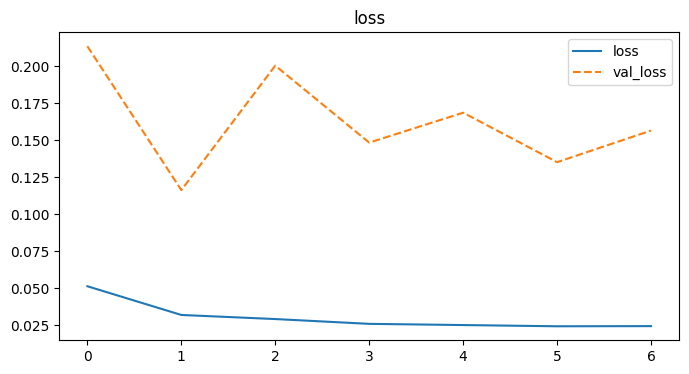

In [33]:
# 3. Build model
# harmonics, model = build_model(
    # train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
# harmonics = data_to_harmonics_function(train_data, data_range)
# processed_signal_FFT = mix_harmonics_function(
#     harmonics, n_harm_lower_limit, n_harm_upper_limit)
# processed_signal = processed_signal_FFT

input_shape = (x_train[list(x_train.keys())[0]].shape[1],1)
model = build_Lstm_model(train_data, prediction_day, input_shape)

history = train_Lstm_model(train_data, model, x_train, y_train)
# Loss
fig, ax = plt.subplots(figsize=(8,4))
plt.title('loss')
plt.plot(history['data_0'].history['loss'], label='loss')
plt.plot(history['data_0'].history['val_loss'], label='val_loss', linestyle='--')
plt.legend()
plt.show()


In [34]:
processed_signal = predicting_creat_processed_signal_Lstm(x_test, test_data, model)
find_signal_pv_function(processed_signal, pv_range)
find_signal_lead_train_function(train_data, processed_signal)

1/1 [==============================] - 2s 2s/step


In [35]:
# 4. Select model
# errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
#                                                                         model, fit_method)
errors = get_fit_error_function(processed_signal, fit_method)
best_fit_harm, best_error = get_best_fit_harm_function(
    processed_signal, errors)
find_signal_lead_test_function(test_data, processed_signal)
first_date, lead, pv = get_first_lead_function(
    processed_signal, best_fit_harm)


In [36]:
# 5. Evaluate model
# result_table, final_error = evaluate_model(
#     model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
result_table = built_result_table_function(
    processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
result_table_process_Lstm_function(
    result_table, all_data, first_date, data_range)
final_error = compute_final_error_function(result_table)
print('final_error = ', final_error)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

final_error =  4.2
            s_date      t_date  lead    ans_date      pv  error best_fit
data_0  2020-01-02  2020-01-08  -3.0  2020-01-03  valley   9.78        0
data_1  2020-01-16  2020-01-30   1.0  2020-01-31  valley  11.36        0
data_2  2020-01-31  2020-02-11  -7.0  2020-01-31  valley  10.95        0
data_3  2020-02-14  2020-03-17   4.0  2020-03-23  valley  10.13        0
data_4  2020-03-02  2020-03-12  -6.0  2020-03-04    peak  10.17        0
data_5  2020-03-16  2020-03-27  -1.0  2020-03-26    peak   11.4        0
data_6  2020-03-30  2020-05-07  -6.0  2020-04-29    peak  11.08        0
data_7  2020-04-14  2020-04-22  -1.0  2020-04-21  valley  11.19        0
data_8  2020-04-28  2020-05-08   3.0  2020-05-13  valley   9.48        0
data_9  2020-05-12  2020-05-22  10.0  2020-06-08    peak   9.68        0


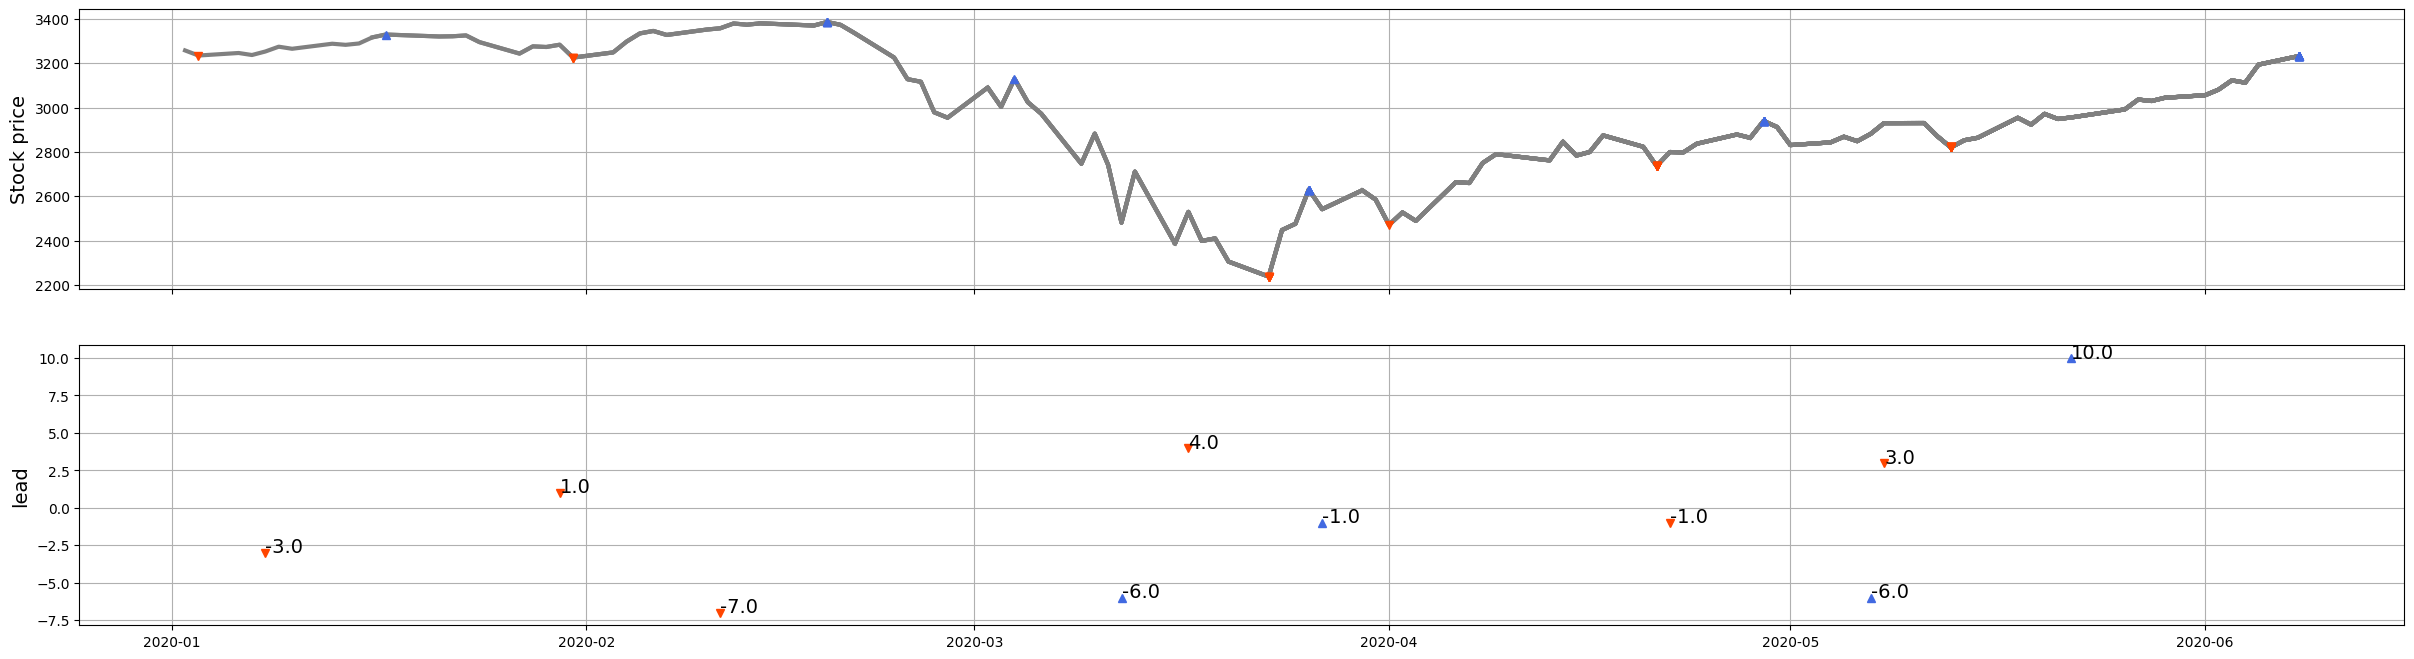

In [37]:
draw_plot_result_table(test_data, all_data, result_table, pv_range)

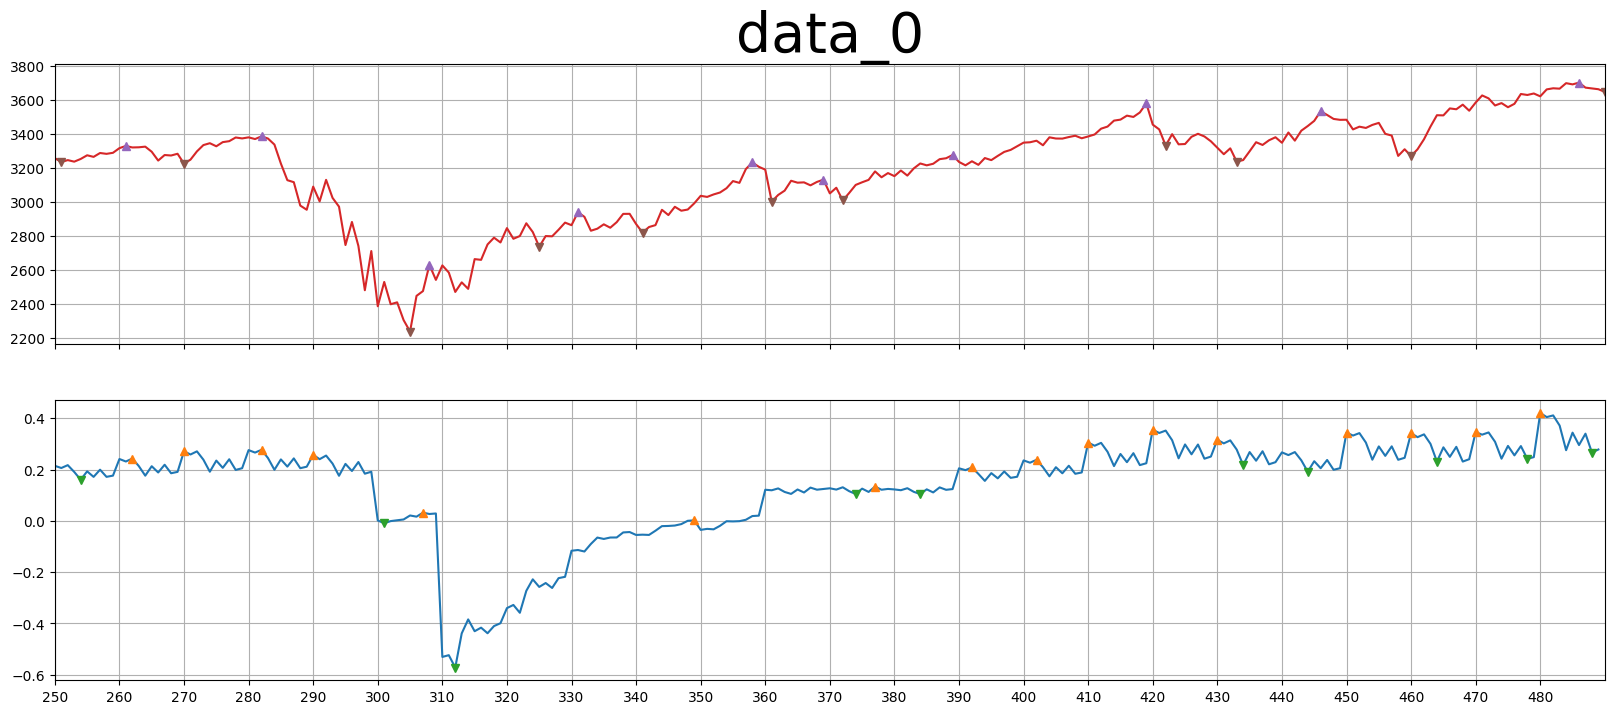

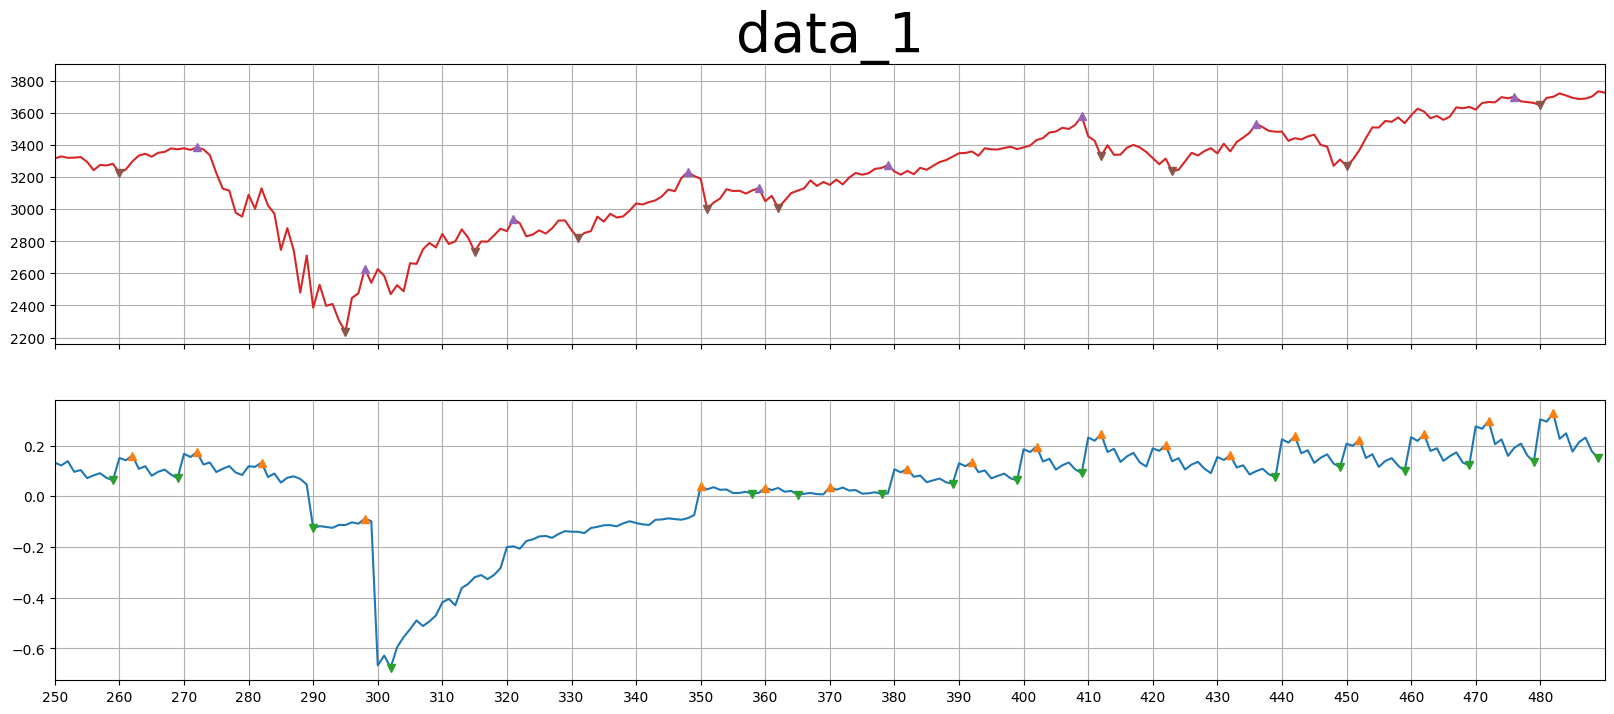

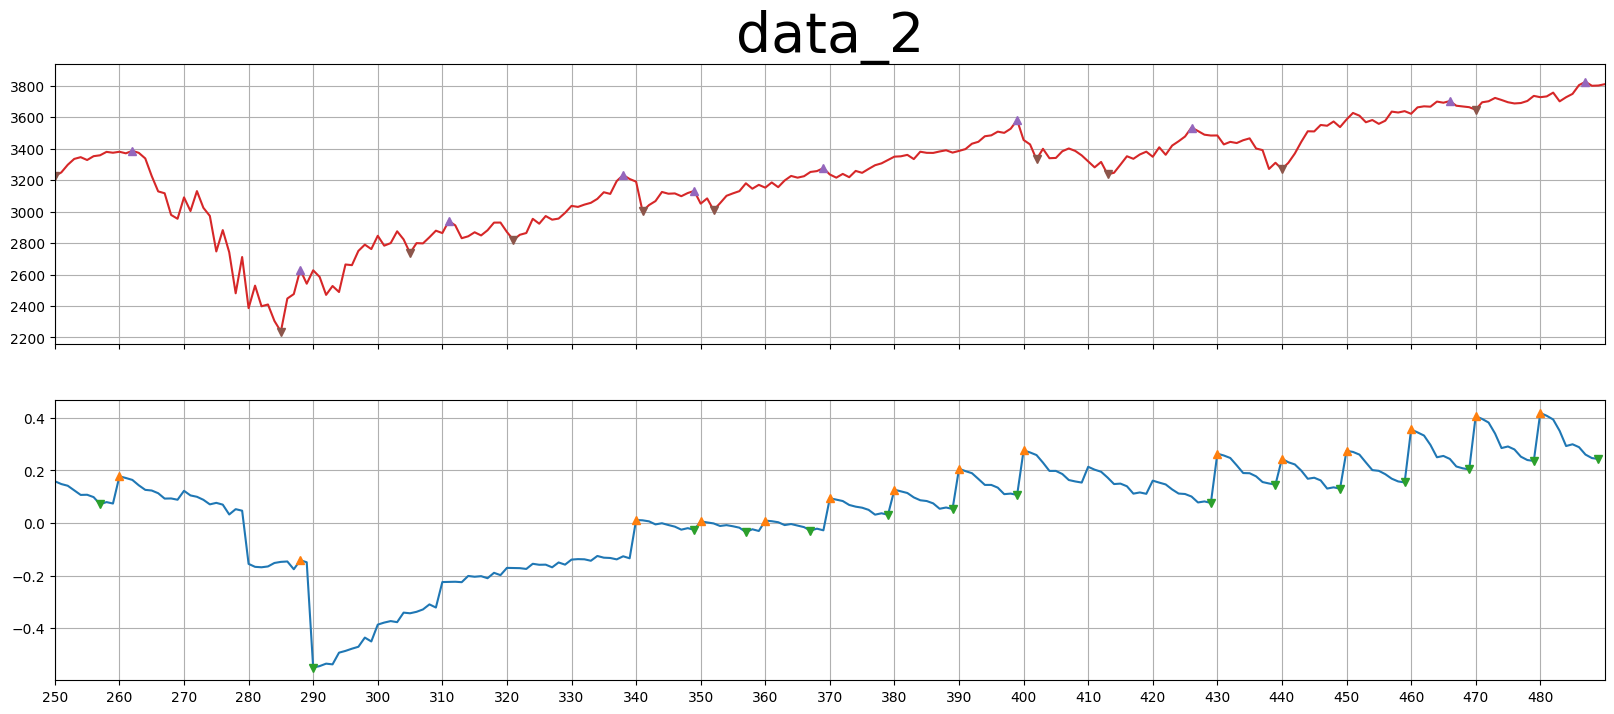

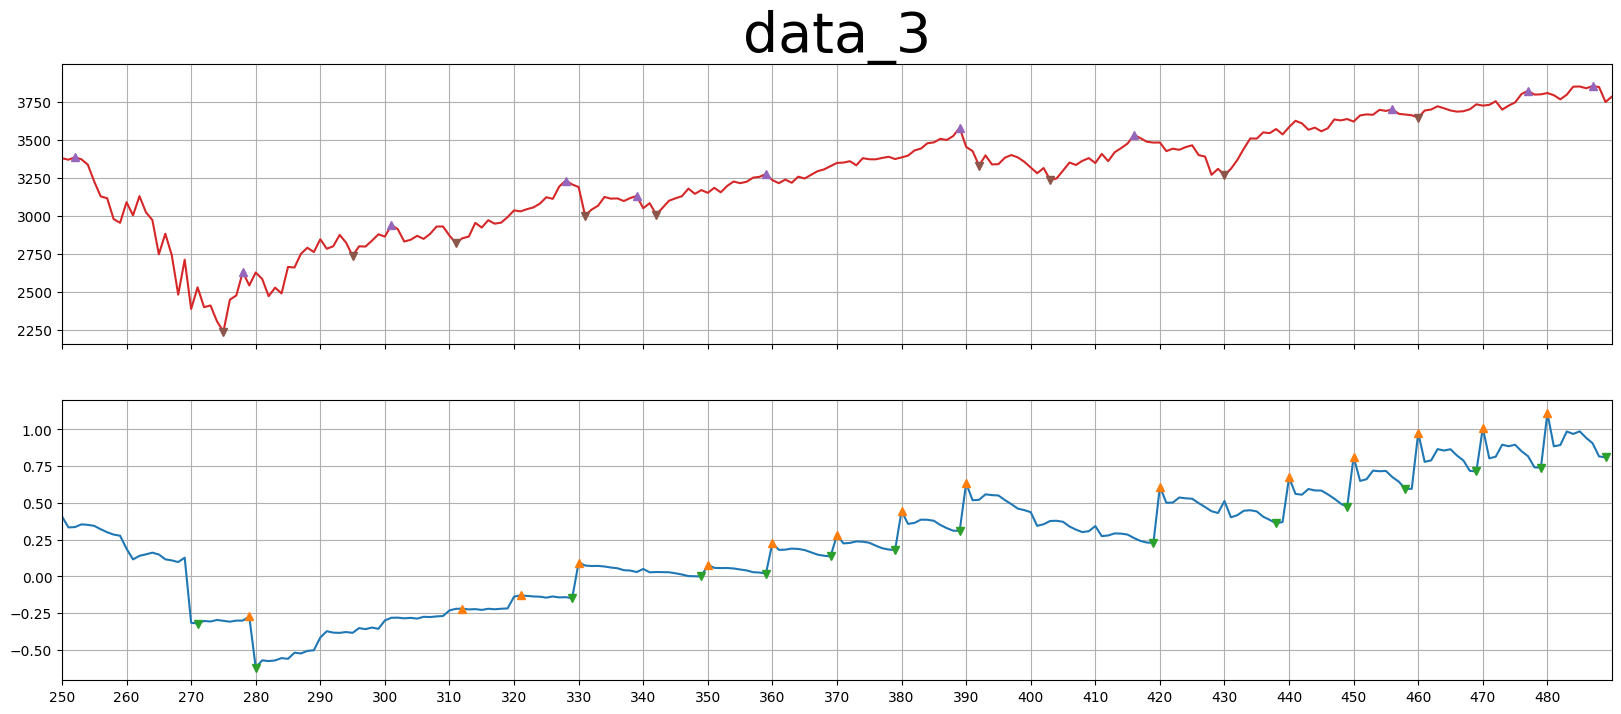

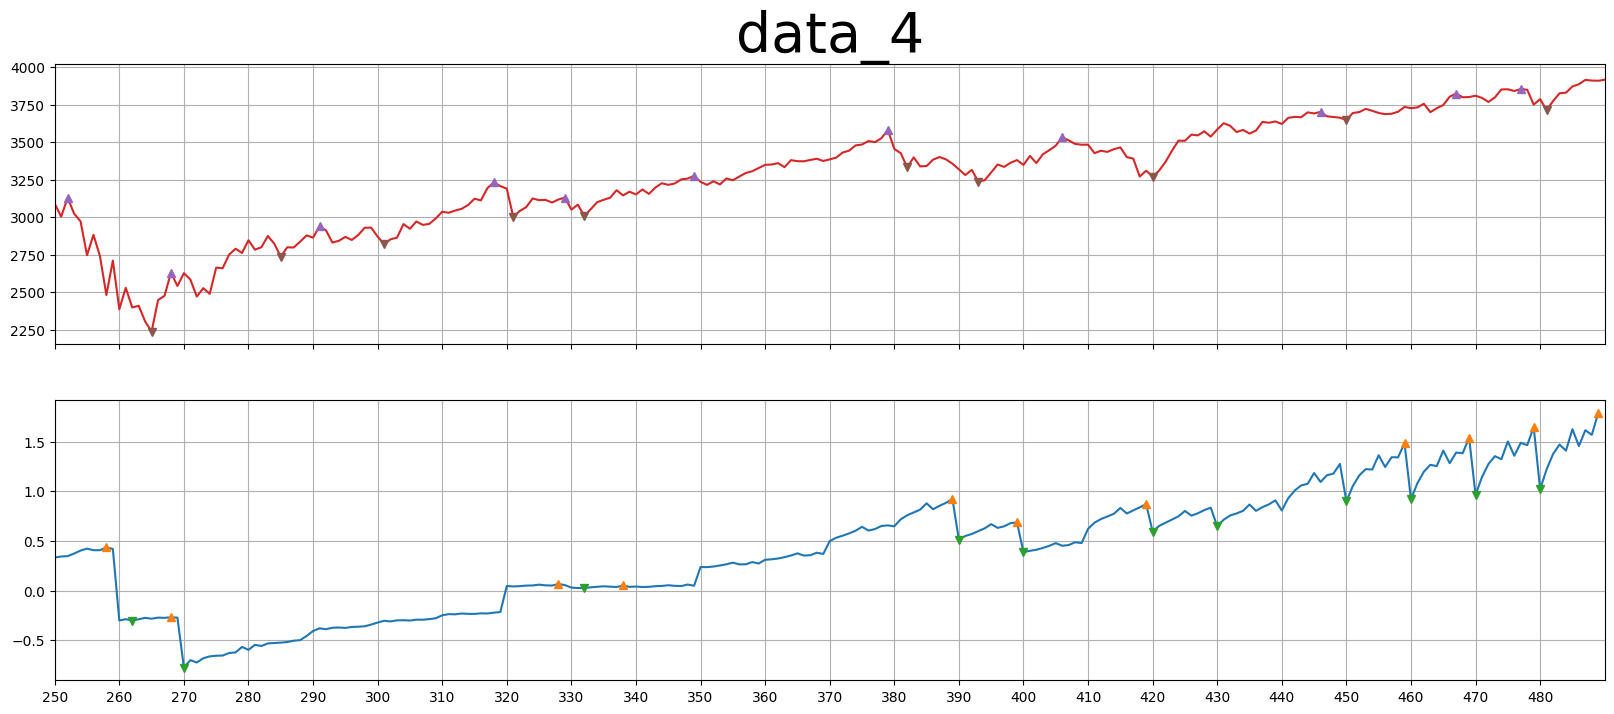

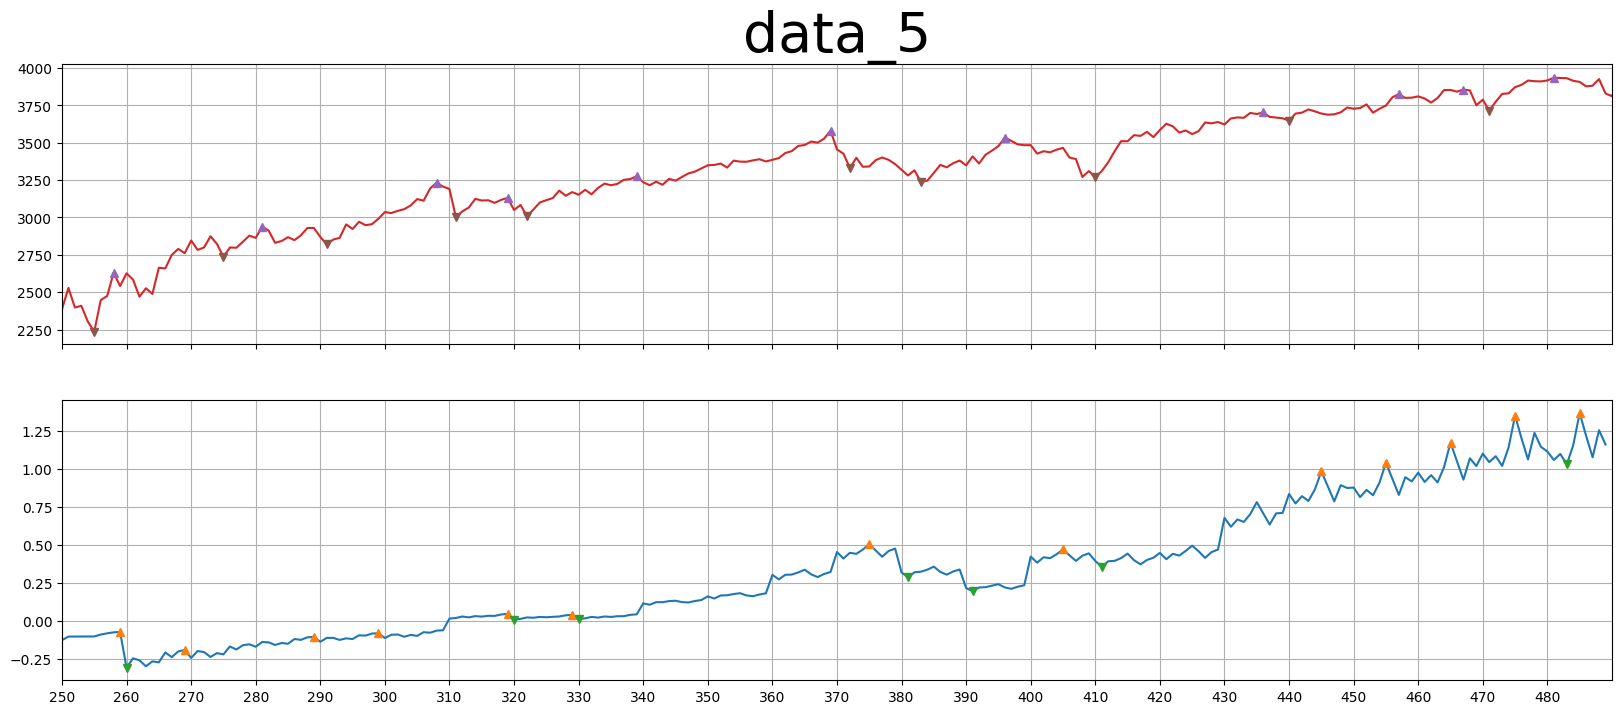

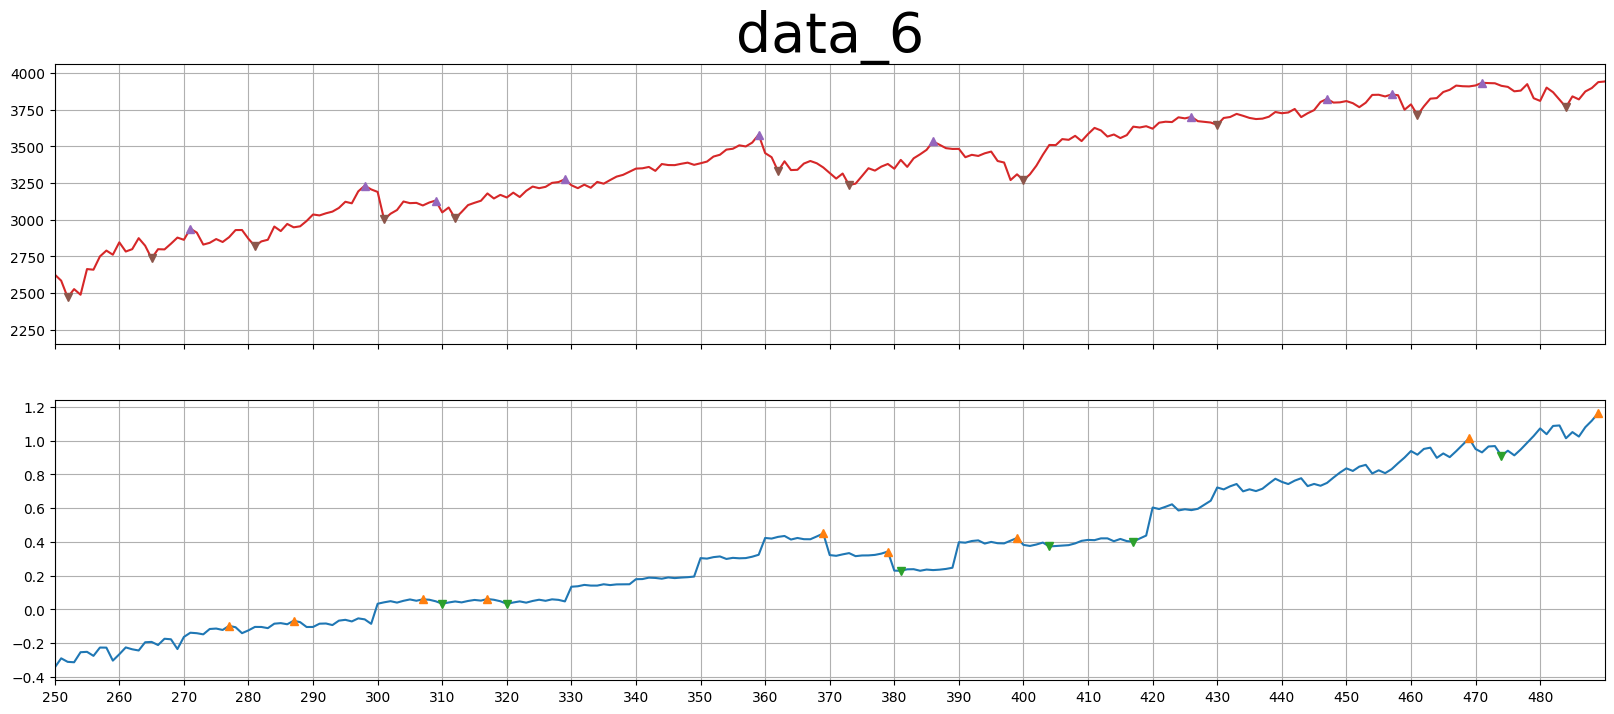

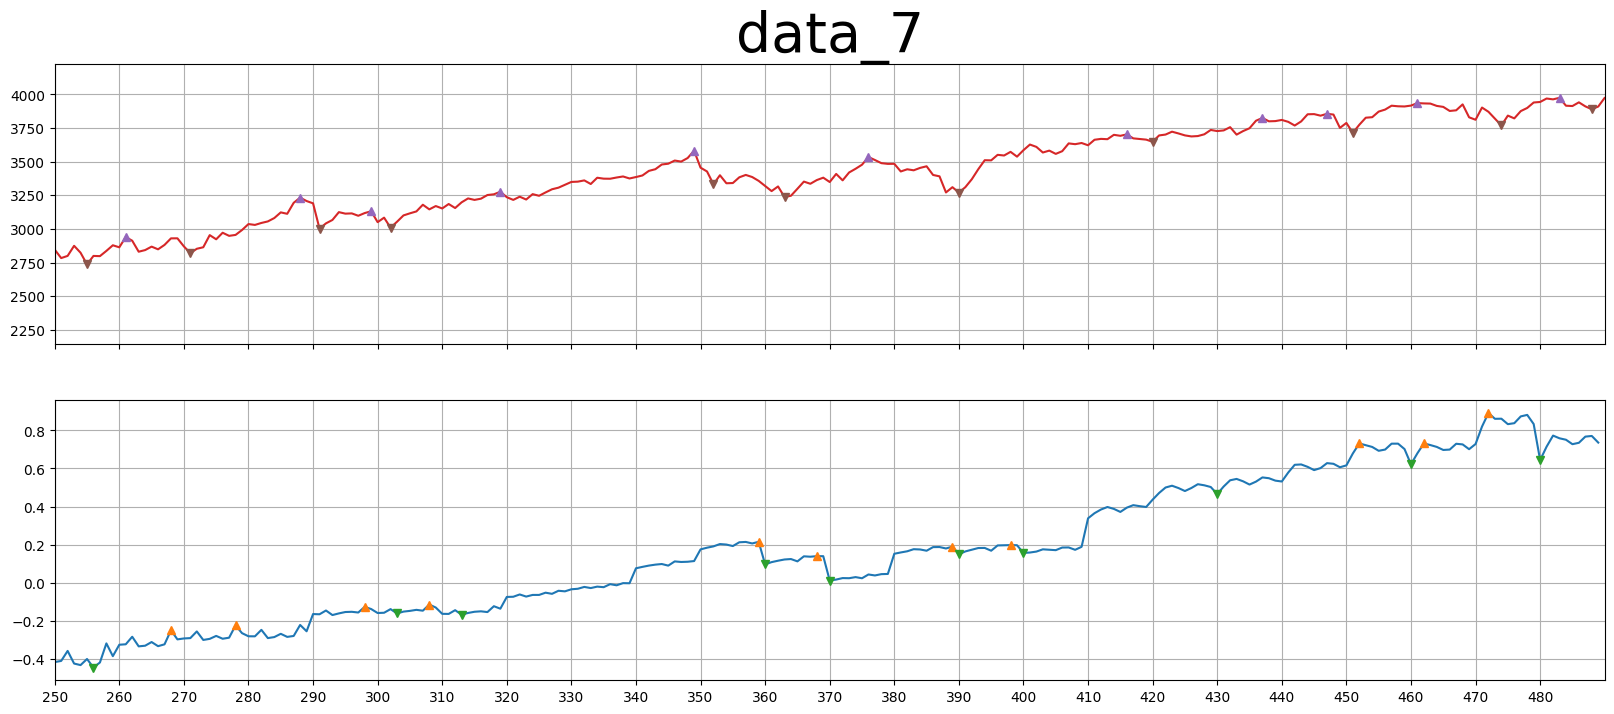

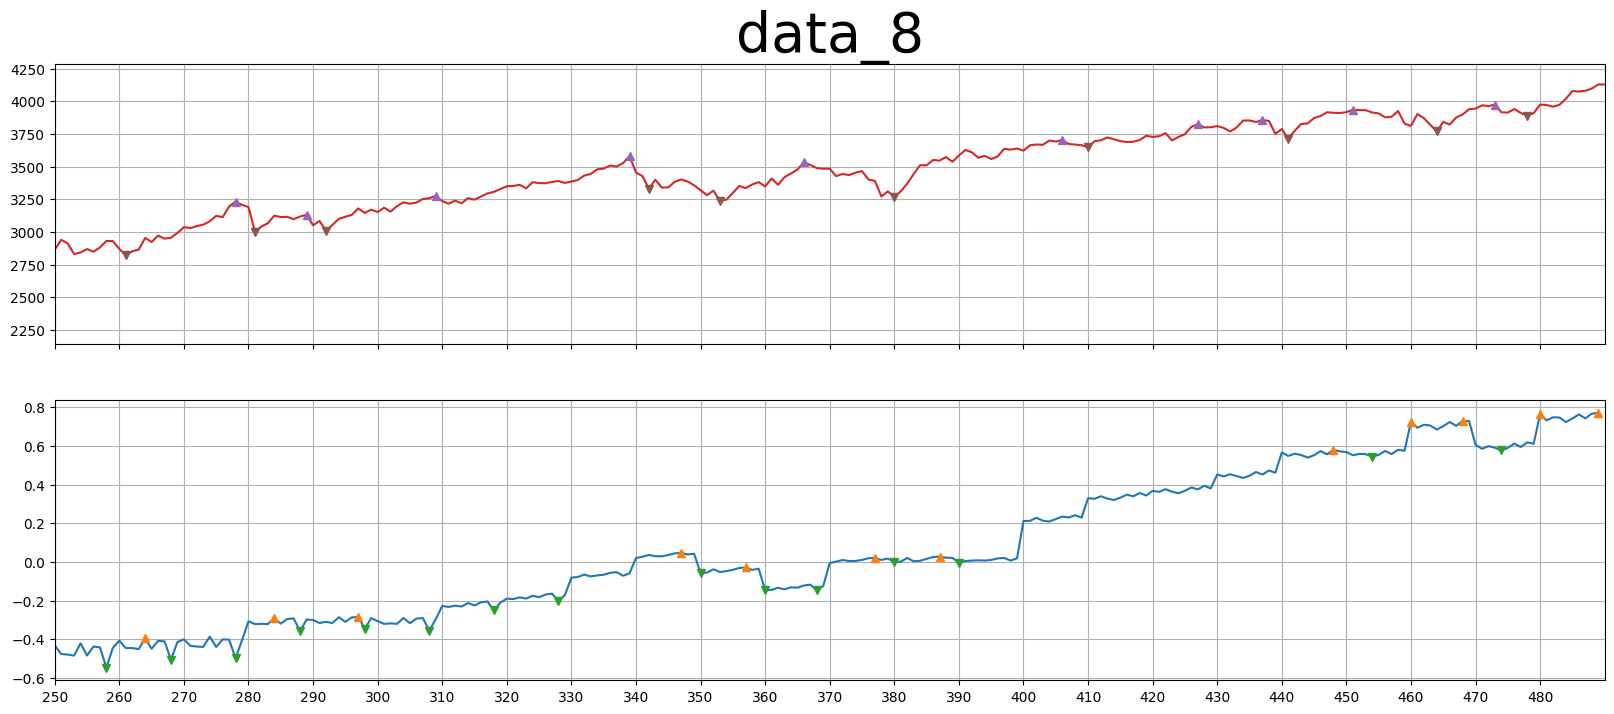

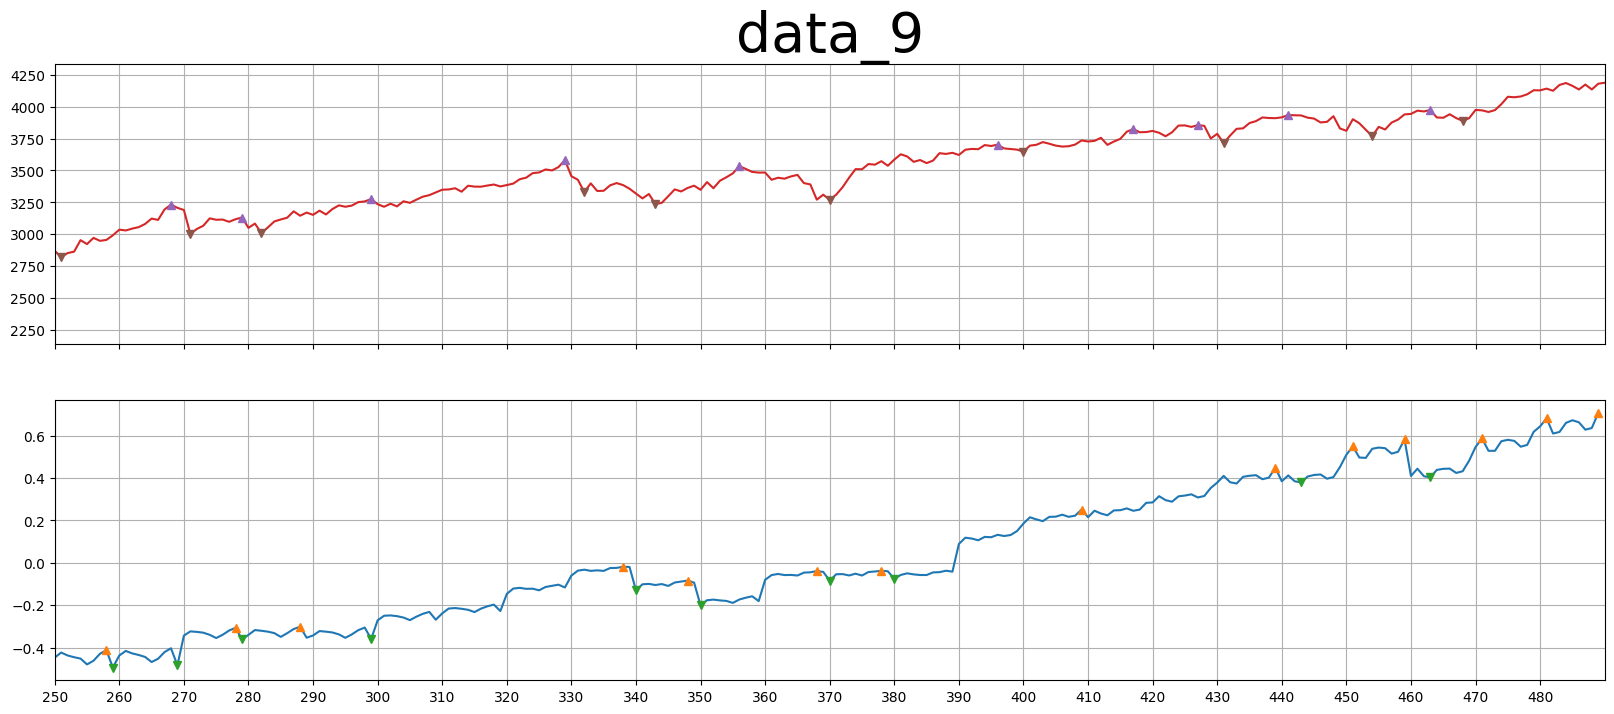

In [38]:
for i in processed_signal:
    fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
    axes[0].set_title(i, fontsize=40)
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['Close'])
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['peaks'], '^')
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['valleys'], 'v')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['Close'])
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['peaks'], '^')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['valleys'], 'v')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['Close'])
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['peaks'], '^')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['valleys'], 'v')
    plt.xlim(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]))
    axes[0].grid()
    axes[1].grid()
    plt.xticks(np.arange(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]), step=10))
    plt.show()

In [39]:
def kbar(open, close, high, low, pos):
    if close > open:             # 上漲
        color='red'                 # 紅 K 棒
        height=close - open   # 高度=收盤-開盤
        bottom=open             # 底部=開盤
    else:                               # 下跌
        color='green'              # 綠 k 棒
        height=open - close   # 高度=開盤-收盤
        bottom=close             # 底部=收盤
    # 繪製 k 棒實體      
    plt.bar(pos, height=height,bottom=bottom, width=1, color=color)
    # 繪製 k 棒上下影線
    plt.vlines(pos, high, low, color=color)

In [40]:
def draw_profit_plot(profit_table, pv_range):
    date_list = sorted(
        list(profit_table['in_date']) + list(profit_table['out_date']))
    plot_data = all_data.loc[date_list[0]:date_list[-1]]
    find_data_pv_function(plot_data, pv_range)
    plt.figure(figsize=(20, 8))
    for i in plot_data.index:
        kbar(plot_data['Open'].loc[i], plot_data['Close'].loc[i], plot_data['High'].loc[i], plot_data['Low'].loc[i], i)
    # plt.plot(plot_data['peaks'], '^', label='peaks', c='royalblue')
    # plt.plot(plot_data['valleys'], 'v', label='valleys', c='orangered')
    for i in profit_table.index:
        if profit_table.loc[i, 'pv'] == 'peak':
            plt.annotate('', xy=(profit_table.loc[i, 'out_date'], profit_table.loc[i, 'out_price']),
                            xytext=(profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price']),
                            arrowprops=dict(facecolor='green', arrowstyle='simple'))

        elif profit_table.loc[i, 'pv'] == 'valley':
            plt.annotate('', xy=(profit_table.loc[i, 'out_date'], profit_table.loc[i, 'out_price']),
                            xytext=(profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price']),
                            arrowprops=dict(facecolor='red', arrowstyle='simple'))
        if 'strategy' in profit_table.columns:
            if profit_table.loc[i, 'strategy'] == 'stop_profit':
                plt.hlines(profit_table.loc[i, 'strategy_price'], profit_table.loc[i, 'in_date'], profit_table.loc[i, 'out_date'], color='red')
            elif profit_table.loc[i, 'strategy'] == 'stop_loss':
                plt.hlines(profit_table.loc[i, 'strategy_price'], profit_table.loc[i, 'in_date'], profit_table.loc[i, 'out_date'], color='green')
            
        # plt.annotate(f'{i}', (profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price']-100), fontsize=14, c='black')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.grid()
    plt.legend()
    plt.show()

In [79]:
def build_profit_table_method_1(result_table):
    profit_table = pd.DataFrame(columns=['in_date', 'in_price', 'out_date', 'out_price', 'pv', 'profit'])
    total_profit = 0
    for i in result_table.index:
        in_price = all_data['Open'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])]
        out_price = all_data['Close'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range]
        if result_table.loc[i, 'pv'] == 'valley':
            profit = out_price - in_price
            profit_table.loc[i, 'pv'] = 'valley'
        else:
            profit = in_price - out_price
            profit_table.loc[i, 'pv'] = 'peak'
        profit_table.loc[i, 'in_date'] = result_table.loc[i, 't_date']
        profit_table.loc[i, 'in_price'] = in_price
        profit_table.loc[i, 'out_date'] = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range].name
        profit_table.loc[i, 'out_price'] = out_price
        profit_table.loc[i, 'profit'] = profit
        total_profit += profit
    return total_profit, profit_table

In [80]:
total_profit, profit_table = build_profit_table_method_1(result_table)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(profit_table)

total_profit = 459.340576171875
           in_date in_price    out_date out_price      pv  profit
data_0  2020-01-08  3238.59  2020-01-17   3329.62  valley   91.03
data_1  2020-01-30  3256.45  2020-02-10   3352.09  valley   95.64
data_2  2020-02-11  3365.87  2020-02-21   3337.75  valley  -28.12
data_3  2020-03-17  2425.66  2020-03-26   2630.07  valley  204.41
data_4  2020-03-12  2630.86  2020-03-23    2237.4    peak  393.46
data_5  2020-03-27  2555.87  2020-04-07   2659.41    peak -103.54
data_6  2020-05-07  2878.26  2020-05-18   2953.91    peak  -75.65
data_7  2020-04-22  2787.89  2020-05-01   2830.71  valley   42.82
data_8  2020-05-08  2908.83  2020-05-19   2922.94  valley   14.11
data_9  2020-05-22  2948.05  2020-06-03   3122.87    peak -174.82


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


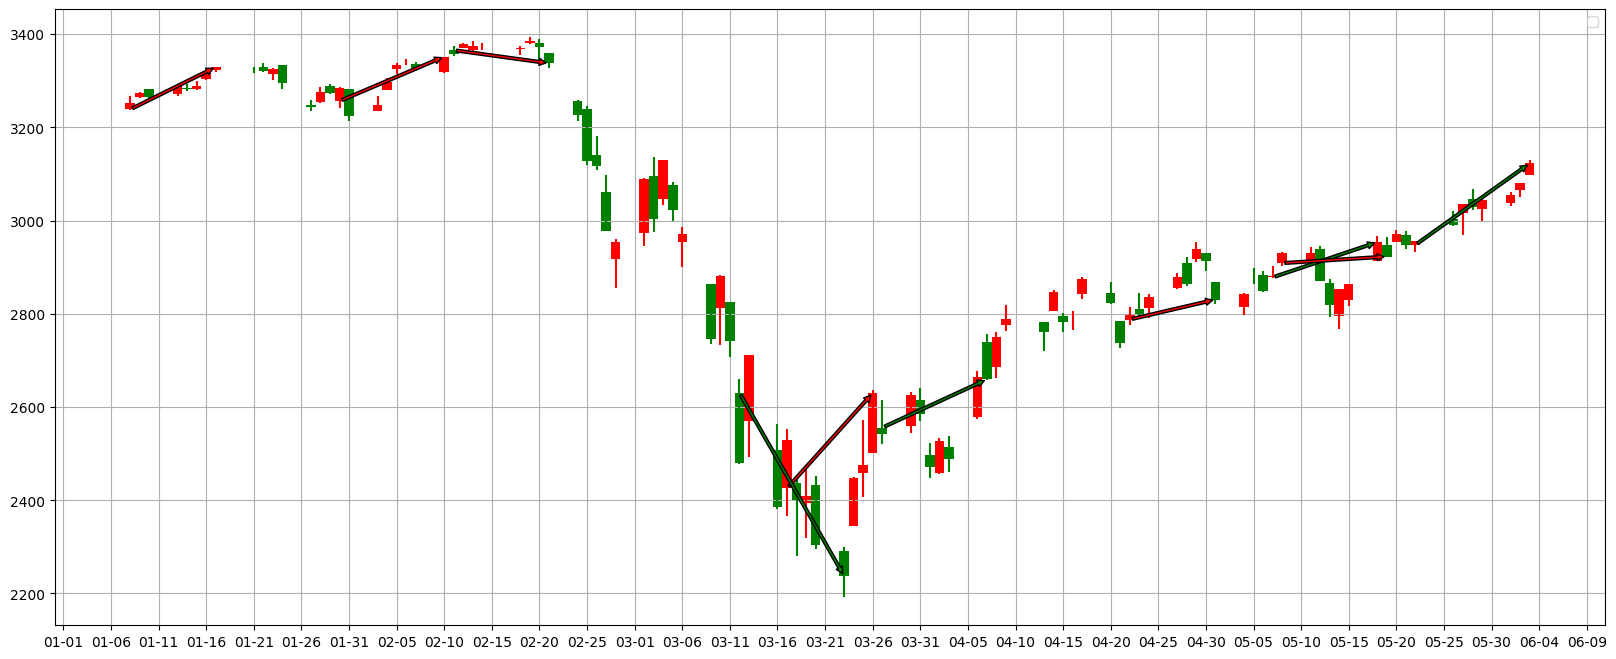

In [81]:
draw_profit_plot(profit_table, pv_range)

In [83]:
def build_profit_table_method_2(result_table, profit_percentage, loss_percentage):
    '''percentage:fioat
    '''
    profit_table = pd.DataFrame(columns=['in_date', 'in_price', 'out_date', 'out_price', 'pv', 'profit', 'strategy', 'strategy_price'])
    total_profit = 0
    for i in result_table.index:
        in_price = all_data['Open'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])]
        if result_table.loc[i, 'pv'] == 'valley':
            stop_profit_price = in_price*(1+profit_percentage)
            stop_loss_price = in_price*(1-loss_percentage)
        else:
            stop_profit_price = in_price*(1-profit_percentage)
            stop_loss_price = in_price*(1+loss_percentage)

        # print(in_price, stop_loss_price, stop_profit_price)
        start_index = all_data.index.get_loc(result_table.loc[i, 't_date'])
        end_index = all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range
        trade_data = all_data.iloc[start_index:end_index]
        # check out_price
        out_price = all_data['Close'].iloc[end_index]
        profit_table.loc[i, 'out_date'] = all_data.iloc[end_index].name
        for j in trade_data.index:
            high = trade_data['High'].loc[j]
            low = trade_data['Low'].loc[j]
            if result_table.loc[i, 'pv'] == 'valley':
                if high>=stop_profit_price:
                    out_price = stop_profit_price
                    profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                    profit_table.loc[i, 'strategy'] = 'stop_profit'
                    profit_table.loc[i, 'strategy_price'] = stop_profit_price
                    break
                elif low<=stop_loss_price:
                    out_price = stop_loss_price
                    profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                    profit_table.loc[i, 'strategy'] = 'stop_loss'
                    profit_table.loc[i, 'strategy_price'] = stop_loss_price
                    break
            elif result_table.loc[i, 'pv'] == 'peak':
                    if low<=stop_profit_price:
                        out_price = stop_profit_price
                        profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                        profit_table.loc[i, 'strategy'] = 'stop_profit'
                        profit_table.loc[i, 'strategy_price'] = stop_profit_price
                        break
                    elif high>=stop_loss_price:
                        out_price = stop_loss_price
                        profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                        profit_table.loc[i, 'strategy'] = 'stop_loss'
                        profit_table.loc[i, 'strategy_price'] = stop_loss_price
                        break

        if result_table.loc[i, 'pv'] == 'valley':
            profit = out_price - in_price
            profit_table.loc[i, 'pv'] = 'valley'
        else:
            profit = in_price - out_price
            profit_table.loc[i, 'pv'] = 'peak'
        profit_table.loc[i, 'in_date'] = result_table.loc[i, 't_date']
        profit_table.loc[i, 'in_price'] = in_price
        
        profit_table.loc[i, 'out_price'] = out_price
        profit_table.loc[i, 'profit'] = profit
        total_profit += profit
    return total_profit, profit_table

In [84]:
total_profit, profit_table = build_profit_table_method_2(result_table, profit_percentage, loss_percentage)


In [85]:
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(profit_table)

total_profit = 328.9663818359372
           in_date in_price    out_date out_price      pv   profit  \
data_0  2020-01-08  3238.59  2020-01-17   3329.62  valley    91.03   
data_1  2020-01-30  3256.45  2020-02-10   3352.09  valley    95.64   
data_2  2020-02-11  3365.87  2020-02-21   3337.75  valley   -28.12   
data_3  2020-03-17  2425.66  2020-03-26   2630.07  valley   204.41   
data_4  2020-03-12  2630.86  2020-03-17  2367.774    peak  263.086   
data_5  2020-03-27  2555.87  2020-04-07   2659.41    peak  -103.54   
data_6  2020-05-07  2878.26  2020-05-18   2953.91    peak   -75.65   
data_7  2020-04-22  2787.89  2020-05-01   2830.71  valley    42.82   
data_8  2020-05-08  2908.83  2020-05-19   2922.94  valley    14.11   
data_9  2020-05-22  2948.05  2020-06-03   3122.87    peak  -174.82   

           strategy strategy_price  
data_0          NaN            NaN  
data_1          NaN            NaN  
data_2          NaN            NaN  
data_3          NaN            NaN  
data_4  sto

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


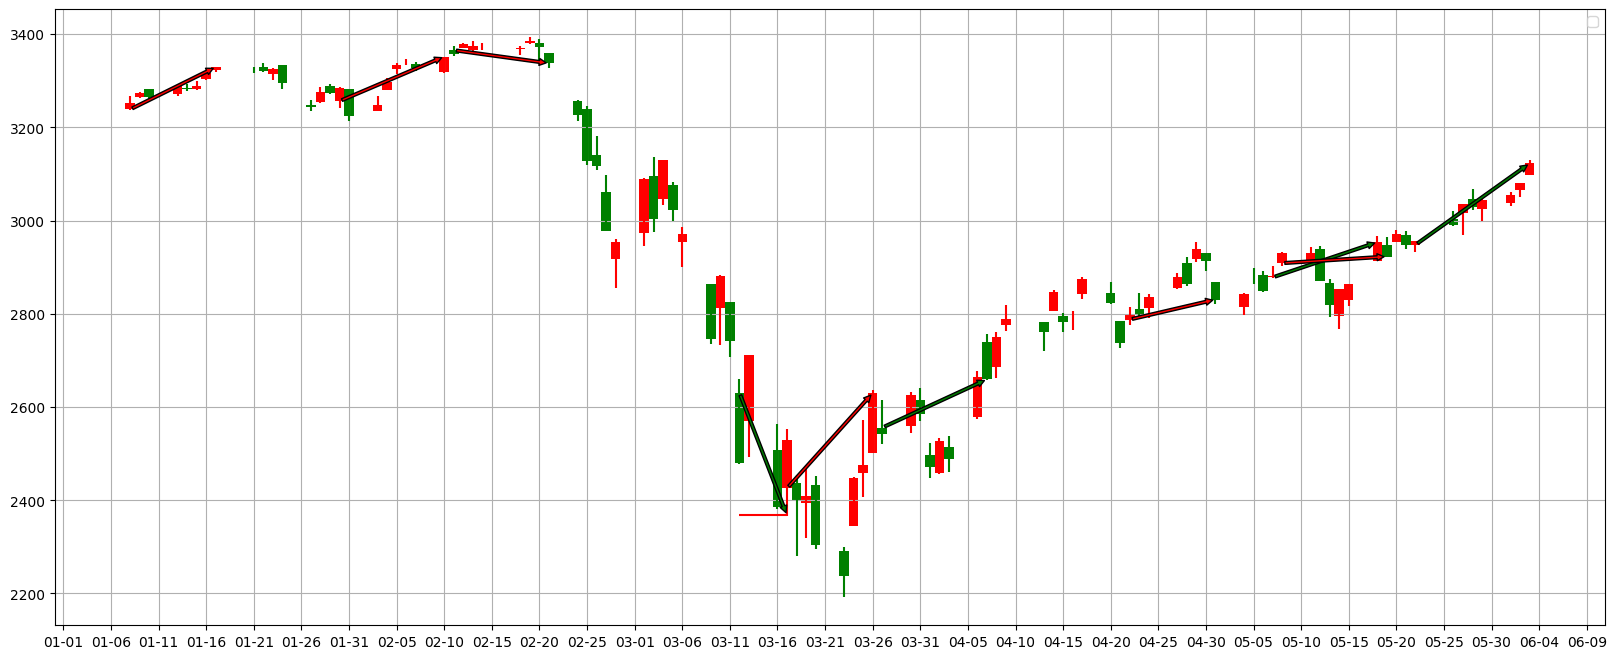

In [86]:
draw_profit_plot(profit_table, pv_range)

In [87]:
def build_profit_table_method_3(result_table, profit_percentage, loss_percentage):
    '''percentage:fioat
    '''
    profit_table = pd.DataFrame(columns=['in_date', 'in_price', 'out_date', 'out_price', 'pv', 'profit', 'strategy', 'strategy_price'])
    total_profit = 0
    for i in result_table.index:
        in_price = all_data['Open'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])]
        # print(in_price, stop_loss_price, stop_profit_price)
        start_index = all_data.index.get_loc(result_table.loc[i, 't_date'])
        end_index = all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range
        trade_data = all_data.iloc[start_index:end_index]
        # check out_price
        out_price = all_data['Close'].iloc[end_index]
        profit_table.loc[i, 'out_date'] = all_data.iloc[end_index].name
        yesterday_close = all_data['Close'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])-1]
        for j in trade_data.index:
            if result_table.loc[i, 'pv'] == 'valley':
                stop_profit_price = yesterday_close*(1+profit_percentage)
                stop_loss_price = yesterday_close*(1-loss_percentage)
            else:
                stop_profit_price = yesterday_close*(1-profit_percentage)
                stop_loss_price = yesterday_close*(1+loss_percentage)
            yesterday_close = trade_data['Close'].loc[j]
            high = trade_data['High'].loc[j]
            low = trade_data['Low'].loc[j]
            if result_table.loc[i, 'pv'] == 'valley':
                if high>=stop_profit_price:
                    out_price = stop_profit_price
                    profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                    profit_table.loc[i, 'strategy'] = 'stop_profit'
                    profit_table.loc[i, 'strategy_price'] = stop_profit_price
                    break
                elif low<=stop_loss_price:
                    out_price = stop_loss_price
                    profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                    profit_table.loc[i, 'strategy'] = 'stop_loss'
                    profit_table.loc[i, 'strategy_price'] = stop_loss_price
                    break
            elif result_table.loc[i, 'pv'] == 'peak':
                    if low<=stop_profit_price:
                        out_price = stop_profit_price
                        profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                        profit_table.loc[i, 'strategy'] = 'stop_profit'
                        profit_table.loc[i, 'strategy_price'] = stop_profit_price
                        break
                    elif high>=stop_loss_price:
                        out_price = stop_loss_price
                        profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                        profit_table.loc[i, 'strategy'] = 'stop_loss'
                        profit_table.loc[i, 'strategy_price'] = stop_loss_price
                        break

        if result_table.loc[i, 'pv'] == 'valley':
            profit = out_price - in_price
            profit_table.loc[i, 'pv'] = 'valley'
        else:
            profit = in_price - out_price
            profit_table.loc[i, 'pv'] = 'peak'
        profit_table.loc[i, 'in_date'] = result_table.loc[i, 't_date']
        profit_table.loc[i, 'in_price'] = in_price
        
        profit_table.loc[i, 'out_price'] = out_price
        profit_table.loc[i, 'profit'] = profit
        total_profit += profit
    return total_profit, profit_table

In [88]:
total_profit, profit_table = build_profit_table_method_3(result_table, profit_percentage, loss_percentage)


In [89]:
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(profit_table)

total_profit = 256.8224609374997
           in_date in_price    out_date out_price      pv   profit  \
data_0  2020-01-08  3238.59  2020-01-17   3329.62  valley    91.03   
data_1  2020-01-30  3256.45  2020-02-10   3352.09  valley    95.64   
data_2  2020-02-11  3365.87  2020-02-21   3337.75  valley   -28.12   
data_3  2020-03-17  2425.66  2020-03-26   2630.07  valley   204.41   
data_4  2020-03-12  2630.86  2020-03-16  2439.918    peak  190.942   
data_5  2020-03-27  2555.87  2020-04-07   2659.41    peak  -103.54   
data_6  2020-05-07  2878.26  2020-05-18   2953.91    peak   -75.65   
data_7  2020-04-22  2787.89  2020-05-01   2830.71  valley    42.82   
data_8  2020-05-08  2908.83  2020-05-19   2922.94  valley    14.11   
data_9  2020-05-22  2948.05  2020-06-03   3122.87    peak  -174.82   

           strategy strategy_price  
data_0          NaN            NaN  
data_1          NaN            NaN  
data_2          NaN            NaN  
data_3          NaN            NaN  
data_4  sto

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


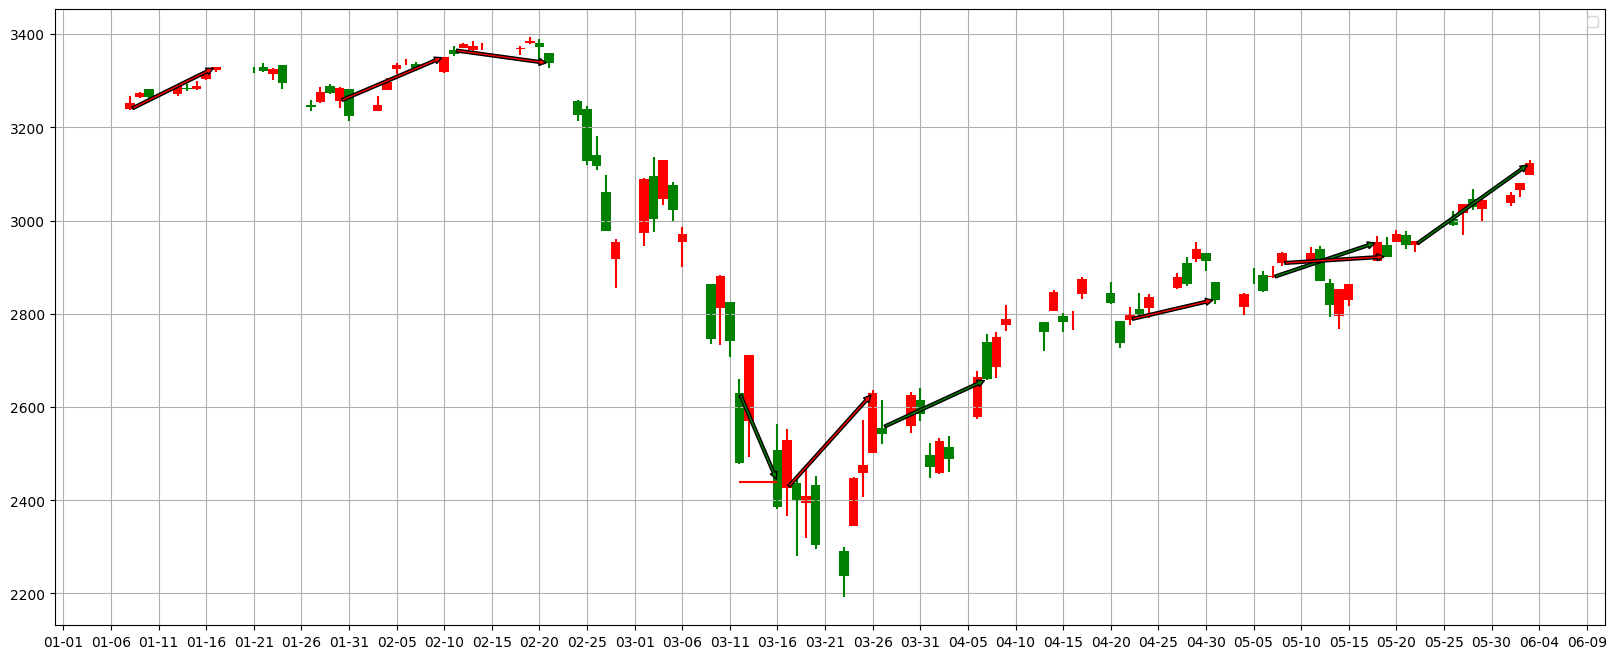

In [90]:
draw_profit_plot(profit_table, pv_range)